In [36]:
%load_ext autoreload
%autoreload 2

from misc import *
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import os 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


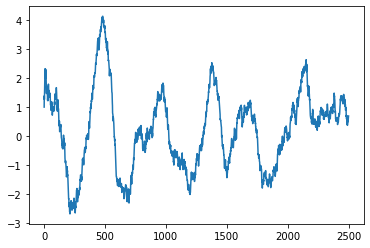

In [24]:
itraj = 1
periods = 5
ppp = 500
method = "euler"
states, covs, signals, [A, dt, C, D ] = load_data(itraj=itraj,method=method, periods=periods, ppp=ppp)
plt.plot(states[:,0])

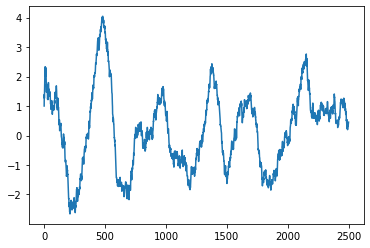

In [48]:
method="RK"
states, covs, signals, [A, dt, C, D ] = load_data(itraj=itraj,method=method, periods=periods, ppp=ppp)
plt.plot(states[:,0])

Construct landscape loss

In [49]:
symplectic = np.array([[0,1],[-1,0]])
e = np.pi/10
parameters = np.arange(0,4*np.pi + e,e)

preds = {t:[] for t in range(len(parameters))}
simulated_states = {t:[[states[0], covs[0]]] for t in range(len(parameters))}


give_pred = lambda st: np.dot(C,st)*dt
xi = lambda cov: np.dot(cov, ct(C)) + ct(D)

def evolve_simu_state(simu_st, simu_a, dy):
    x, cov = simu_st
    XiCov = xi(cov)
    dx = np.dot(simu_a - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(simu_a,cov) + np.dot(cov, ct(simu_a)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    return [x + dx, cov + dcov]


for dy in tqdm(signals):
    for i in range(len(parameters)):
        preds[i].append(give_pred(simulated_states[i][-1][0]))
        simulated_states[i].append(evolve_state(simulated_states[i][-1], parameters[i]*symplectic, dy))
        
        
landscape = {}
cut_series = [int(k) for k in np.logspace(2,np.log10(len(signals)),10)]
for length_series in tqdm(cut_series):
    losses = []
    for i in range(len(parameters)):
        losses.append(np.sum(np.square(np.array(preds[i])[:length_series] - signals[:length_series]))/(2*dt*length_series))
    landscape[length_series] = losses
    
path_landscape=get_def_path()+"{}periods/{}ppp/{}/cost_landscape/".format(periods,ppp,itraj)
os.makedirs(path_landscape,exist_ok=True)
np.save(path_landscape+method,list(landscape.values()), allow_pickle=True)

100%|██████████| 10/10 [00:00<00:00, 22.10it/s]


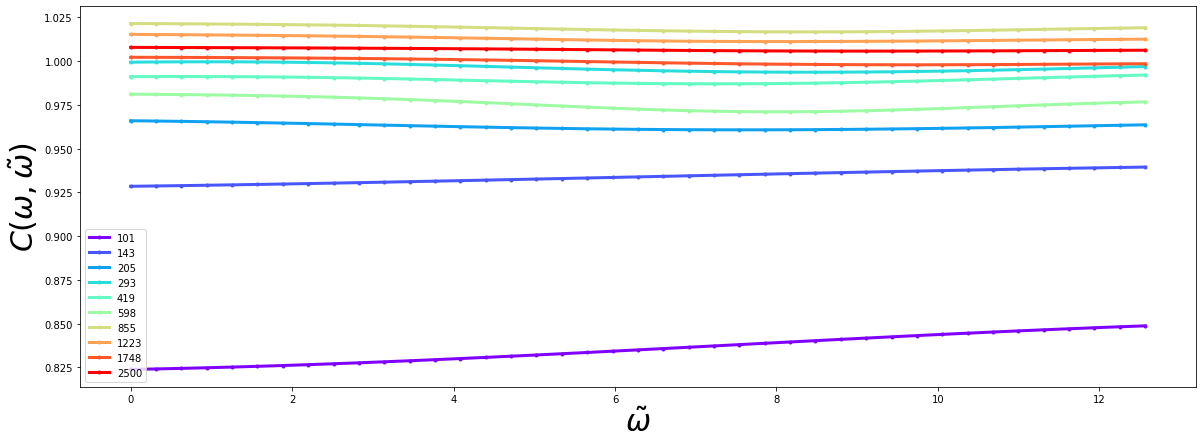

In [50]:
plt.figure(figsize=(20,7))
colors = plt.get_cmap("rainbow")
ax = plt.subplot2grid((1,1),(0,0))
for ind,p in enumerate(landscape.values()):
    plt.plot(parameters,p, color=colors(np.linspace(0,1,len(landscape)))[ind], marker='.', label="{}".format(int(np.round(cut_series[ind]+1,0))),linewidth=3)
plt.legend()
plt.xlabel(r'$\tilde{\omega}$',size=30)
plt.ylabel(r'$C(\omega, \tilde{\omega})$',size=30)
plt.savefig(path_landscape+"{}.pdf".format(method))